# Assignment 1 Applied Deep Learning

## imports for the tasks

We unified the common blocks of the training and evaluation process of a network.
In a lot of parts is a type evaluation disitinguishing working with the CIFAR10 dataset or the other.

In [ ]:
from skimage import io
import torch
from torchvision import models
import torchvision
import torch.nn as nn
import numpy as np
import random
from IPython.display import clear_output
import time
import os.path
import torch.nn.functional as F
from sklearn.metrics import f1_score
import torchvision.transforms as tt
from matplotlib.pylab import plt
from numpy import arange
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.init
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import CIFAR10
from google.colab import files

This distinguishing between the datasets that are currently used, shows naturally the first time at the moment where the data is loaded.

In [ ]:
def iloader(path):
    image = np.asarray((io.imread(path))/32000,dtype='float32')
    return image.transpose(2,0,1)

def Load_data(cifar=False, train_set=None, test_set=None):
    if not cifar:
      data = torchvision.datasets.DatasetFolder(root=root,loader = iloader, transform=None, extensions = 'jpg')
      train_set, test_set = train_test_split(data, test_size=0.2, stratify=data.targets)
    num_train = len(train_set)
    print("Number of images in original training set: " + str(num_train) + "+" + str(len(test_set)))
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = len(test_set)
    print("Split Number: " + str(split))
    training_idx, valid_idx = indices[split:], indices[:split]
    print("Number of training images: " + str(len(training_idx)))
    print("Number of validation images: " + str(len(valid_idx)))

    print("Number of images in the testing set: " + str(len(test_set)))
    training_sampler = SubsetRandomSampler(training_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    batch_size = 16 # 16 images per batch

    #  Training Set
    train_loader = torch.utils.data.DataLoader(dataset = train_set, \
                                              batch_size = batch_size, \
                                              sampler = training_sampler)

    #Validation Set
    valid_loader = torch.utils.data.DataLoader(dataset = train_set, \
                                              batch_size = batch_size, \
                                              sampler = training_sampler)

    # Testing Set
    # Here, you do not need the "sampler" input, since you did not change the original testing set
    testing_loader = torch.utils.data.DataLoader(dataset = test_set, \
                                              batch_size = batch_size, \
                                              shuffle = True)


    return train_loader, valid_loader, testing_loader


After defining how they data is loaded we also define the function that we used to plot the training loss. There we dont count the epochs from the 0. Instead we display the first epoch as 1.

In [ ]:
def plot_loss_curve(train_loss,num_epochs):
  epochs = range(1, num_epochs+1)

  # Plot and label the training and validation loss values
  plt.plot(epochs, train_loss, label='Training Loss')


  # Add in a title and axes labels
  plt.title('Training loss per epoch')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  # Set the tick locations
  plt.xticks(arange(1, num_epochs+1, 1))

  # Display the plot
  plt.legend(loc='best')
  plt.savefig("loss_curve.png")
  files.download("loss_curve.png")

### This class defines the architecture of our model used to work with the CIFAR-10 dataset

In [ ]:
# Let's build your first CNN model
cifar_num_classes=10
class nnModel(nn.Module):
  def __init__(self, number_of_classes):
    super(nnModel, self).__init__() # NN Module Initialization
    # 1st Convolutional layer
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
    # 2nd Convolutional layer
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1, padding=1)
    # 3rd Convolutional layer
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    # 4th Convolutional layer
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    # 5th Convolutional layer
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)

    # 1st Fully Connected layer (Linear layer)
    self.fc1 = nn.Linear(in_features=256*4*4, out_features=64)

    # 2nd Fully Connected layer (Linear layer)
    self.fc2 = nn.Linear(in_features=64, out_features=64)

    # 3rd Fully Connected layer (Linear layer)
    self.fc3 = nn.Linear(in_features=64, out_features=number_of_classes) # Last layer's output must be the same as the number of classes/categories

    #batchnorm layers
    self.bn1 = nn.BatchNorm2d(8)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(128)
    self.bn5 = nn.BatchNorm2d(256)

    #max Pool layers
    self.max1 = nn.MaxPool2d(2)
    self.max2 = nn.MaxPool2d(2)
    self.max3 = nn.MaxPool2d(2)
    # Dropout
    self.dropout1 = nn.Dropout(p=0.15)
    self.dropout2 = nn.Dropout(p=0.15)

  def forward(self, x):
    # In the "forward" function, you define the behaviour of your CNN
    # Activation functions are also implemented in the "forward" function
    # 1st Convolutional + Pooling Block
    x = self.conv1(x)
    x = F.leaky_relu(x)
    x = self.bn1(x)

    x = self.conv2(x)
    x = F.leaky_relu(x)
    x = self.max1(x)
    x = self.bn2(x)
    x = F.leaky_relu(x)

    #2nd Convolutional + Pooling Block
    x = self.conv3(x)
    x = F.leaky_relu(x)
    x = self.bn3(x)

    x = self.conv4(x)
    x = F.leaky_relu(x)
    x = self.max2(x)
    x = self.bn4(x)
    x = F.leaky_relu(x)

    #3rd Convolutional + Pooling Block
    x = self.conv5(x)
    x = self.max3(x)
    x = F.leaky_relu(x)

    # Before passing features to the linear layers, you need to "flatten" the features.
    flat_x = x.view(x.shape[0], -1)

    # 1st Fully Connected layer (Linear layer)
    flat_x = F.relu(self.fc1(flat_x))
    flat_x = self.dropout1(flat_x) # You can use dropout wherever you "want"
    # 2nd Fully Connected layer (Linear layer)
    flat_x = F.leaky_relu(self.fc2(flat_x))
    flat_x = self.dropout1(flat_x) # You can use dropout wherever you "want"
    # 3rd Fully Connected layer (Linear layer)
    flat_x = self.fc3(flat_x) # Usually, last layer does not need activation layer

    return flat_x


This again is combined codeblock from the first and second part of the assignment. Depending on which part you want to work with. It's possible to load the required model either the predefined ones from scratch or the the CNN we defined for the first part.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def Load_model(model="mobile_net", pretrained=False):
    if model=="mobile_net":
      model_ft= torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=pretrained)
      out_num= 32
    elif model =="our_model":
      model_ft = nnModel(cifar_num_classes)
      cnn_model = model_ft.to(device)
      return cnn_model
    else:
      model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=pretrained)
      out_num =64
    num_ftrs = model_ft.classifier[-1].in_features
    model_ft.classifier[-1] = nn.Linear(num_ftrs, 10)
    inBands = 3
    model_ft.features[0]= nn.Conv2d(inBands, out_num, kernel_size=3, stride=1, padding = 1, bias = False)
    print('Model Loaded')

    print('\nThe model will run on', device)
    cnn_model = model_ft.to(device)
    return cnn_model

This codeblock allows to load the required data. So the data is available on the Colab drive to work with it and train the models on it.

In [ ]:
data_folder = '/content/sample_data/'
#root = os.path.join(data_folder, '2750/')
root = '2750/'
download_ON = os.path.exists(root)

if not download_ON:
    # This can be long...
    #os.chdir(data_folder)
  os.system('wget http://madm.dfki.de/files/sentinel/EuroSAT.zip') #Just RGB Bands
  !unzip EuroSAT.zip
  download_ON = True


transform = tt.ToTensor()

training_data = CIFAR10(download=True, root="./data" , transform=transform)
testing_data = CIFAR10(download=True, root="./ data", train=False , transform=transform)


This initializes and loads the splits for the CIFAR-10 dataset

In [ ]:
cifar_train_loader, cifar_val_loader, cifar_test_loader = Load_data(cifar=True,train_set= training_data,test_set= testing_data)

Number of images in original training set: 50000+10000
Split Number: 10000
Number of training images: 40000
Number of validation images: 10000
Number of images in the testing set: 10000


This is the corresponding block for the 2nd part. It allows to load the sentinel data accordingly.

In [ ]:
train_loader, val_loader, test_loader =Load_data()

This block defines a common function to train a network that is applicable to both parts of the assignment. That ensure that similar Hyperparameters are used across the training process, where it is only necessary to adapt them once.

In [ ]:
# To train a CNN, you must choose (or develop) a loss function, an optimizer algorithm, and a set of hyper-parameters (learning rate, number of epochs, etc)
# Hyper-parameters
num_epochs = 10
lr = 0.001

def train(cnn_model,train_loader, val_loader, num_epochs = num_epochs, lr = lr):
  # Loss Function
  criterion = nn.CrossEntropyLoss() # Cross entropy loss function is widely used in classification problems
  # Optimizer Algorithm
  optimizer = optim.Adam(cnn_model.parameters(), lr = lr)
  step_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  # Training
  running_loss = 0.0

  # Initialize an empty list to store the training losses per epoch
  training_losses = []

  # Training loop

  for epoch in range(num_epochs):
    epoch_loss = 0.0
    count = 0
    for batch_id, data in enumerate(train_loader, 0):
      # Get the images and their labels
      images, labels = data
      # Send the images and their labels to the training device
      images, labels = images.to(device), labels.to(device)

      # Pass images through the CNN
      outputs = cnn_model(images)

      # Create a loss value
      loss = criterion(outputs, labels)

      # Backpropagation
      optimizer.zero_grad() # zero the parameter gradients
      loss.backward()
      optimizer.step()

      # Check some statistics
      running_loss += loss.item()
      if batch_id % 1000 == 999: # prints every 1000 batchs
        print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_id + 1, running_loss / 1000))
        epoch_loss += running_loss / len(train_loader)
        count += 1
        running_loss = 0.0

    training_losses.append(epoch_loss/count)

    # For each epoch, analize the model performance
    valid_correct = 0
    valid_total = 0
    valid_total_loss = 0
    with torch.no_grad():
      for valid_batch_id, valid_data in enumerate(val_loader, 0):
        valid_images, valid_labels = valid_data
        valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
        valid_outputs = cnn_model(valid_images)
        valid_loss = criterion(valid_outputs, valid_labels)
        valid_total_loss += valid_loss.item()
        _, valid_predicted = torch.max(valid_outputs.data, 1)
        valid_total += valid_labels.size(0)
        valid_correct += (valid_predicted == valid_labels).sum().item()
    print("(Validation Set) Epoch: " + str(epoch + 1) + " Acc: " + str(100*valid_correct/valid_total))
    step_scheduler.step()
  plot_loss_curve(training_losses, num_epochs)
  print("Training is completed!")





Similar to the training function this allows the same for the testing process of the networks.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def test(cnn_model, test_loader, num_classes):
  num_classes =10
  # Evaluate a CNN is similar to the training process without the backpropagation.
  # To evaluate a CNN, we need to follow the evaluation metrics
  #class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  correct = 0
  total = 0
  class_correct = list(0. for i in range(num_classes))
  class_total = list(0. for i in range(num_classes))
  class_preds = list(0. for i in range(num_classes))
  recalls = list(0. for i in range(num_classes))
  precisions = list(0. for i in range(num_classes))

  conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]

  cnn_model.eval()

  preds = []
  y = []

  with torch.no_grad(): # You are not training, so you don't need to calculate gradients
    for batch_id, data in enumerate(test_loader, 0):
      # Get the images and their labels
      images, labels = data
      # Send the images and their labels to the training device
      images, labels = images.to(device), labels.to(device)

      # Calculate the CNN's predictions by running images through the network
      outputs = cnn_model(images)

      # The class with the highest
      _, predicted = torch.max(outputs.data, 1)

      # Get model's performance
      # -------------------------------------------------------
      # ----------------- Compute metrics here ----------------
      # -------------------------------------------------------
      correct += sum(predicted==labels)
      labels = labels.detach().cpu().numpy()
      predicted = predicted.detach().cpu().numpy()



      for pred, lab in zip(predicted, labels):
        total += 1
        preds.append(pred)
        y.append(lab)
        class_total[lab] += 1
        class_preds[pred]+=1
        if pred == lab:
          class_correct[lab] += 1

    conf_matrix = confusion_matrix(preds, y)
    conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
    # Adjust this based on the actual number of classes
    df_cm = pd.DataFrame(conf_matrix)
    plt.figure(figsize=(12, 7))
    sns.heatmap(df_cm, annot=True)
    plt.savefig("confusion_matrix.png")
    files.download("confusion_matrix.png")
  # Show model's performance
  print('Accuracy using {} test images: {} %\n'.format(total,100 * correct / total))

  # Performance per Class
  for i in range(num_classes):
    if class_total[i] == 0:
      print('Accuracy of %2s : %2d %% in %d Images' % (i, 0, 0))
    else:
      print('Accuracy of %2s : %2d %% in %d Images' % (i, 100 * class_correct[i] / class_total[i], class_total[i]))
      print('Recall of %2s : %3s  ' % (i, class_correct[i]/ class_total[i] ))
      if class_preds[i] != 0:
        print('Precision of %2s : %3s  ' % (i, class_correct[i]/ class_preds[i]))
        precisions[i] = class_correct[i]/ class_preds[i]
      else:
        print('Precision of 0')
        precisions[i] = 0
      recalls[i] =class_correct[i]/ class_total[i]

  avg_recall= sum(recalls)/num_classes
  avg_precision = sum(precisions)/num_classes
  print(f'\nAvarege recall: {avg_recall}')
  print(f'\nAvarege precision: {avg_precision}')
  print(f'F1 score: {(2*avg_recall*avg_precision)/(avg_recall+avg_precision)}')


In this part all the different models are initialized and then in a later part of the notebook they are serially trained after each other.

In [ ]:
our_model = Load_model(model="our_model")
cnn_model_mobile = Load_model(model="mobile_net")

cnn_model_alex = Load_model()
cnn_model_mobile_pretrained = Load_model(model="mobile_net", pretrained=True)
cnn_model_alex_pretrained = Load_model( pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `w

Model Loaded

The model will run on cuda
Model Loaded

The model will run on cuda


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 73.7MB/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Model Loaded

The model will run on cuda
Model Loaded

The model will run on cuda


This is the training process of the model used in part 1 of the assignment. The output shows the last run that was made with the parameters
- no StepLR
- 20 Epochs
- LR: 0.001


[1,  1000] loss: 1.714
[1,  2000] loss: 1.342
(Validation Set) Epoch: 1 Acc: 61.08
[2,  1000] loss: 1.668
[2,  2000] loss: 1.002
(Validation Set) Epoch: 2 Acc: 70.9625
[3,  1000] loss: 1.325
[3,  2000] loss: 0.844
(Validation Set) Epoch: 3 Acc: 75.745
[4,  1000] loss: 1.155
[4,  2000] loss: 0.713
(Validation Set) Epoch: 4 Acc: 80.11
[5,  1000] loss: 0.985
[5,  2000] loss: 0.623
(Validation Set) Epoch: 5 Acc: 81.2375
[6,  1000] loss: 0.849
[6,  2000] loss: 0.552
(Validation Set) Epoch: 6 Acc: 84.4
[7,  1000] loss: 0.728
[7,  2000] loss: 0.500
(Validation Set) Epoch: 7 Acc: 86.9275
[8,  1000] loss: 0.635
[8,  2000] loss: 0.431
(Validation Set) Epoch: 8 Acc: 88.6275
[9,  1000] loss: 0.564
[9,  2000] loss: 0.387
(Validation Set) Epoch: 9 Acc: 91.1225
[10,  1000] loss: 0.498
[10,  2000] loss: 0.351
(Validation Set) Epoch: 10 Acc: 91.5
[11,  1000] loss: 0.456
[11,  2000] loss: 0.308
(Validation Set) Epoch: 11 Acc: 92.365
[12,  1000] loss: 0.404
[12,  2000] loss: 0.289
(Validation Set) Epoch:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training is completed!


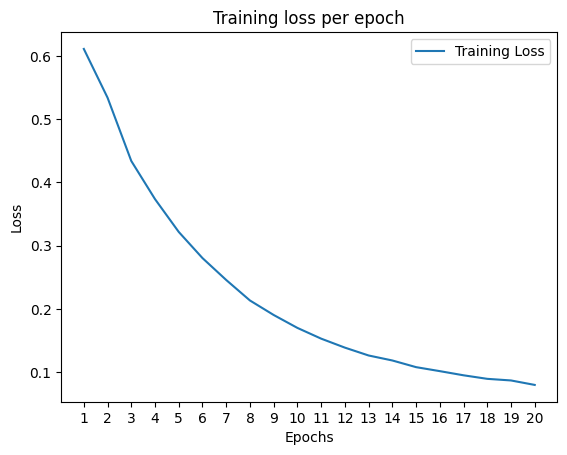

In [ ]:
our_model = Load_model(model="our_model")

train(our_model, cifar_train_loader, cifar_val_loader)

## This block is added for the purpose of creating the report

It imports a python package which can directly create graphs from the architecture defined in code, might throw errors used in a different way


In [ ]:
!pip install torchview

In [ ]:
import torchvision
from torchview import draw_graph

model_graph = draw_graph(our_model, input_size=(16,3,32,32), expand_nested=True)
model_graph.resize_graph(scale=5.0)
model_graph.visual_graph.render(format='png')
model_graph.visual_graph

This is the corresponding evaluation process of part1 of the assignment, which evaluates the currently trained model and calculates a lot of metrics to help to understand issues that might be present with the architecture.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy using 10000 test images: 77.7699966430664 %

Accuracy of  0 : 79 % in 1000 Images
Recall of  0 : 0.792  
Precision of  0 : 0.825  
Accuracy of  1 : 88 % in 1000 Images
Recall of  1 : 0.887  
Precision of  1 : 0.913491246138002  
Accuracy of  2 : 67 % in 1000 Images
Recall of  2 : 0.67  
Precision of  2 : 0.6864754098360656  
Accuracy of  3 : 62 % in 1000 Images
Recall of  3 : 0.621  
Precision of  3 : 0.5994208494208494  
Accuracy of  4 : 75 % in 1000 Images
Recall of  4 : 0.758  
Precision of  4 : 0.7260536398467433  
Accuracy of  5 : 68 % in 1000 Images
Recall of  5 : 0.686  
Precision of  5 : 0.7021494370522006  
Accuracy of  6 : 85 % in 1000 Images
Recall of  6 : 0.852  
Precision of  6 : 0.7859778597785978  
Accuracy of  7 : 73 % in 1000 Images
Recall of  7 : 0.733  
Precision of  7 : 0.8939024390243903  
Accuracy of  8 : 89 % in 1000 Images
Recall of  8 : 0.894  
Precision of  8 : 0.8498098859315589  
Accuracy of  9 : 88 % in 1000 Images
Recall of  9 : 0.884  
Precision 

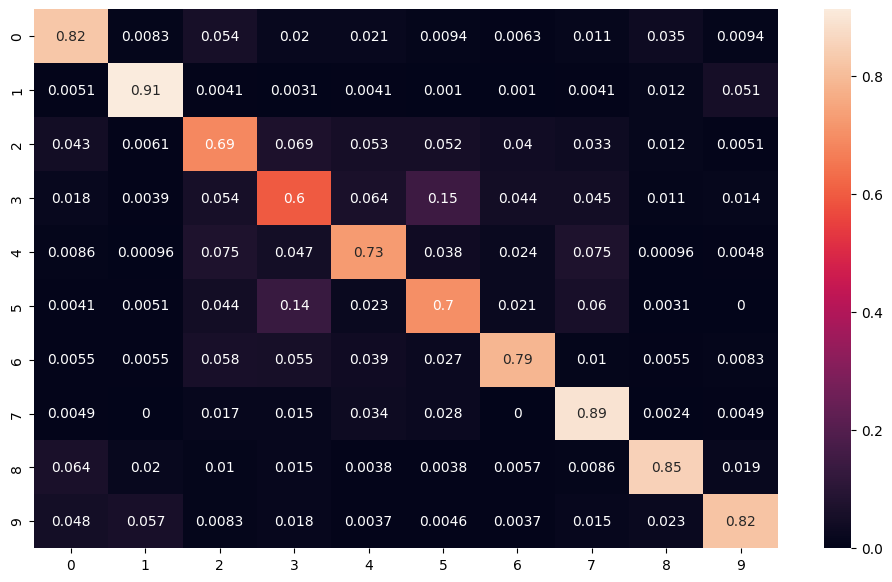

In [ ]:
test(our_model, cifar_test_loader, cifar_num_classes)

## This block indicates that after that the training and evaluation process of part 2 starts

[1,  1000] loss: 1.269
(Validation Set) Epoch: 1 Acc: 60.29012345679013
[2,  1000] loss: 0.935
(Validation Set) Epoch: 2 Acc: 69.06172839506173
[3,  1000] loss: 0.773
(Validation Set) Epoch: 3 Acc: 77.81481481481481
[4,  1000] loss: 0.640
(Validation Set) Epoch: 4 Acc: 82.54320987654322
[5,  1000] loss: 0.522
(Validation Set) Epoch: 5 Acc: 85.24691358024691
[6,  1000] loss: 0.317
(Validation Set) Epoch: 6 Acc: 90.88888888888889
[7,  1000] loss: 0.249
(Validation Set) Epoch: 7 Acc: 92.95679012345678
[8,  1000] loss: 0.211
(Validation Set) Epoch: 8 Acc: 93.77777777777777
[9,  1000] loss: 0.179
(Validation Set) Epoch: 9 Acc: 94.53703703703704
[10,  1000] loss: 0.149
(Validation Set) Epoch: 10 Acc: 95.74691358024691


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training is completed!


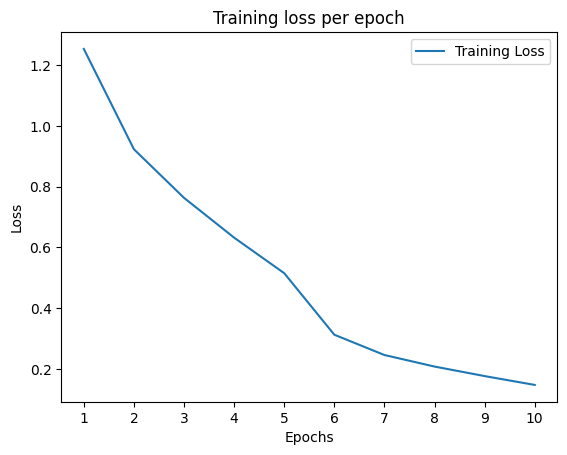

In [ ]:
train(cnn_model_mobile,train_loader,val_loader)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy using 5400 test images: 92.72222137451172 %

Accuracy of  0 : 94 % in 600 Images
Recall of  0 : 0.9483333333333334  
Precision of  0 : 0.8821705426356589  
Accuracy of  1 : 98 % in 600 Images
Recall of  1 : 0.9833333333333333  
Precision of  1 : 0.9752066115702479  
Accuracy of  2 : 92 % in 600 Images
Recall of  2 : 0.9216666666666666  
Precision of  2 : 0.8229166666666666  
Accuracy of  3 : 92 % in 500 Images
Recall of  3 : 0.926  
Precision of  3 : 0.9429735234215886  
Accuracy of  4 : 96 % in 500 Images
Recall of  4 : 0.964  
Precision of  4 : 0.9469548133595285  
Accuracy of  5 : 92 % in 400 Images
Recall of  5 : 0.9225  
Precision of  5 : 0.902200488997555  
Accuracy of  6 : 77 % in 500 Images
Recall of  6 : 0.772  
Precision of  6 : 0.908235294117647  
Accuracy of  7 : 93 % in 600 Images
Recall of  7 : 0.9316666666666666  
Precision of  7 : 0.9824253075571178  
Accuracy of  8 : 89 % in 500 Images
Recall of  8 : 0.89  
Precision of  8 : 0.9388185654008439  
Accuracy of  9

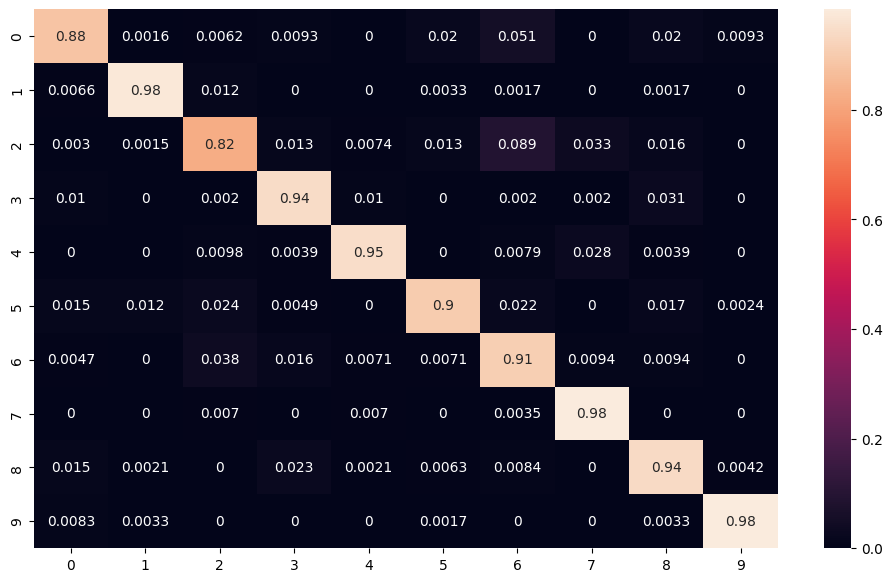

In [ ]:
test(cnn_model_mobile, test_loader, 10)

[1,  1000] loss: 1.246
(Validation Set) Epoch: 1 Acc: 66.78395061728395
[2,  1000] loss: 0.887
(Validation Set) Epoch: 2 Acc: 73.27777777777777
[3,  1000] loss: 0.718
(Validation Set) Epoch: 3 Acc: 79.54320987654322
[4,  1000] loss: 0.601
(Validation Set) Epoch: 4 Acc: 81.32098765432099
[5,  1000] loss: 0.509
(Validation Set) Epoch: 5 Acc: 86.64197530864197
[6,  1000] loss: 0.305
(Validation Set) Epoch: 6 Acc: 91.24691358024691
[7,  1000] loss: 0.241
(Validation Set) Epoch: 7 Acc: 91.74074074074075
[8,  1000] loss: 0.208
(Validation Set) Epoch: 8 Acc: 93.20370370370371
[9,  1000] loss: 0.183
(Validation Set) Epoch: 9 Acc: 94.77160493827161
[10,  1000] loss: 0.157
(Validation Set) Epoch: 10 Acc: 95.25308641975309


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training is completed!


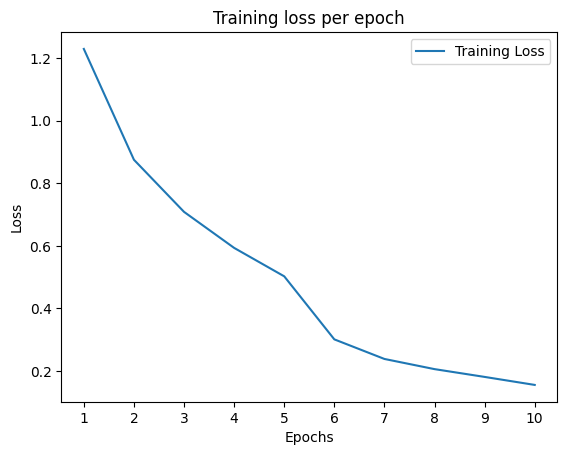

In [ ]:
train(cnn_model_alex,train_loader,val_loader)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy using 5400 test images: 92.53703308105469 %

Accuracy of  0 : 90 % in 600 Images
Recall of  0 : 0.9083333333333333  
Precision of  0 : 0.922165820642978  
Accuracy of  1 : 98 % in 600 Images
Recall of  1 : 0.9833333333333333  
Precision of  1 : 0.9866220735785953  
Accuracy of  2 : 87 % in 600 Images
Recall of  2 : 0.8783333333333333  
Precision of  2 : 0.85  
Accuracy of  3 : 89 % in 500 Images
Recall of  3 : 0.89  
Precision of  3 : 0.9388185654008439  
Accuracy of  4 : 95 % in 500 Images
Recall of  4 : 0.954  
Precision of  4 : 0.950199203187251  
Accuracy of  5 : 93 % in 400 Images
Recall of  5 : 0.935  
Precision of  5 : 0.8738317757009346  
Accuracy of  6 : 83 % in 500 Images
Recall of  6 : 0.83  
Precision of  6 : 0.8283433133732535  
Accuracy of  7 : 97 % in 600 Images
Recall of  7 : 0.97  
Precision of  7 : 0.9748743718592965  
Accuracy of  8 : 90 % in 500 Images
Recall of  8 : 0.906  
Precision of  8 : 0.9417879417879418  
Accuracy of  9 : 98 % in 600 Images
Recall o

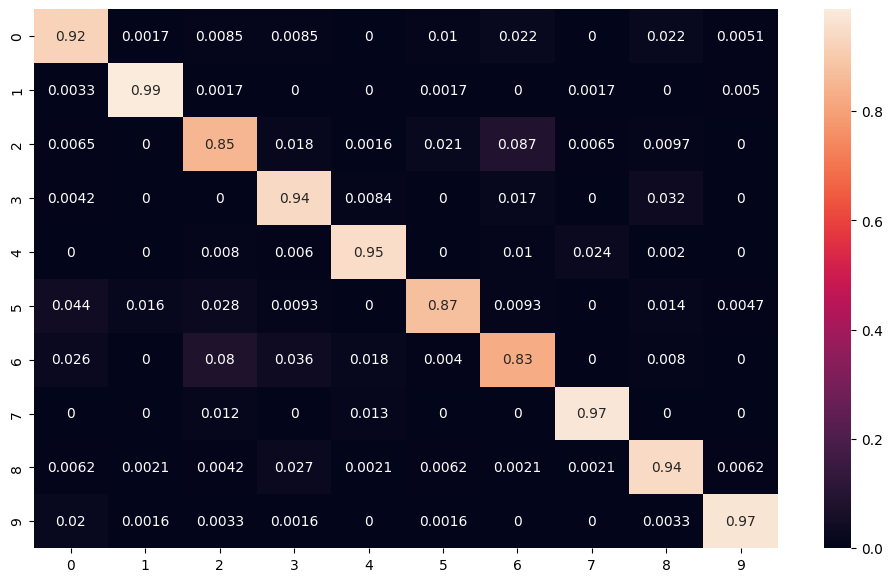

In [ ]:
test(cnn_model_alex, test_loader, 10)

[1,  1000] loss: 0.685
(Validation Set) Epoch: 1 Acc: 87.32098765432099
[2,  1000] loss: 0.376
(Validation Set) Epoch: 2 Acc: 91.05555555555556
[3,  1000] loss: 0.307
(Validation Set) Epoch: 3 Acc: 92.39506172839506
[4,  1000] loss: 0.276
(Validation Set) Epoch: 4 Acc: 92.71604938271605
[5,  1000] loss: 0.236
(Validation Set) Epoch: 5 Acc: 92.34567901234568
[6,  1000] loss: 0.104
(Validation Set) Epoch: 6 Acc: 97.20987654320987
[7,  1000] loss: 0.079
(Validation Set) Epoch: 7 Acc: 97.95061728395062
[8,  1000] loss: 0.064
(Validation Set) Epoch: 8 Acc: 98.17901234567901
[9,  1000] loss: 0.052
(Validation Set) Epoch: 9 Acc: 98.54938271604938
[10,  1000] loss: 0.046
(Validation Set) Epoch: 10 Acc: 98.91975308641975


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training is completed!


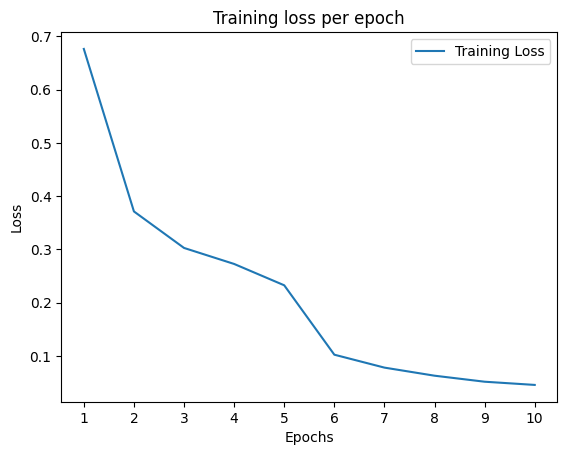

In [ ]:
train(cnn_model_mobile_pretrained, train_loader,val_loader)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy using 5400 test images: 97.44444274902344 %

Accuracy of  0 : 96 % in 600 Images
Recall of  0 : 0.9666666666666667  
Precision of  0 : 0.9682804674457429  
Accuracy of  1 : 99 % in 600 Images
Recall of  1 : 0.9916666666666667  
Precision of  1 : 0.9949832775919732  
Accuracy of  2 : 98 % in 600 Images
Recall of  2 : 0.98  
Precision of  2 : 0.92018779342723  
Accuracy of  3 : 99 % in 500 Images
Recall of  3 : 0.99  
Precision of  3 : 0.9763313609467456  
Accuracy of  4 : 97 % in 500 Images
Recall of  4 : 0.974  
Precision of  4 : 0.9838383838383838  
Accuracy of  5 : 95 % in 400 Images
Recall of  5 : 0.9575  
Precision of  5 : 0.9720812182741116  
Accuracy of  6 : 92 % in 500 Images
Recall of  6 : 0.926  
Precision of  6 : 0.9706498951781971  
Accuracy of  7 : 99 % in 600 Images
Recall of  7 : 0.99  
Precision of  7 : 0.99  
Accuracy of  8 : 96 % in 500 Images
Recall of  8 : 0.968  
Precision of  8 : 0.9817444219066938  
Accuracy of  9 : 98 % in 600 Images
Recall of  9 : 0.988

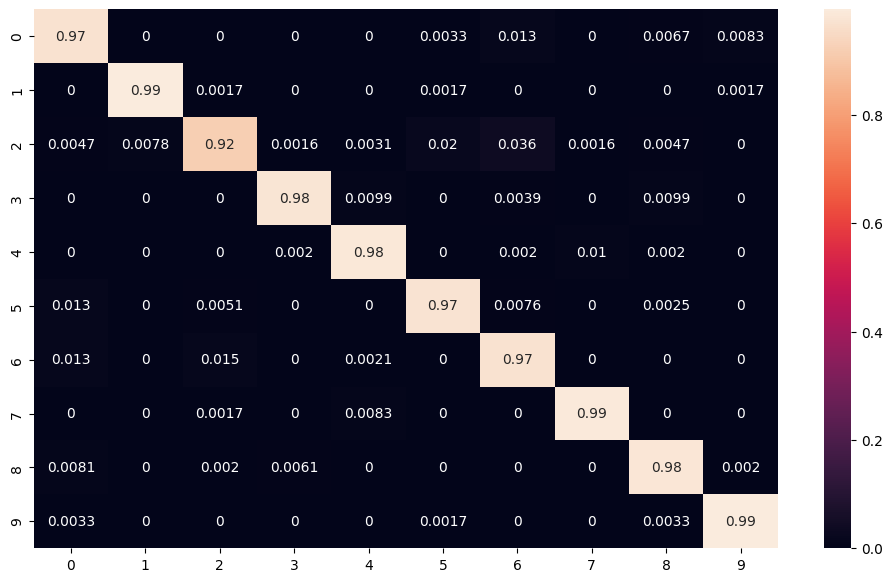

In [ ]:
test(cnn_model_mobile_pretrained, test_loader, 10)

[1,  1000] loss: 0.673
(Validation Set) Epoch: 1 Acc: 85.20370370370371
[2,  1000] loss: 0.385
(Validation Set) Epoch: 2 Acc: 90.61111111111111
[3,  1000] loss: 0.302
(Validation Set) Epoch: 3 Acc: 90.26543209876543
[4,  1000] loss: 0.261
(Validation Set) Epoch: 4 Acc: 93.37654320987654
[5,  1000] loss: 0.230
(Validation Set) Epoch: 5 Acc: 94.15432098765432
[6,  1000] loss: 0.096
(Validation Set) Epoch: 6 Acc: 97.48148148148148
[7,  1000] loss: 0.073
(Validation Set) Epoch: 7 Acc: 97.91358024691358
[8,  1000] loss: 0.060
(Validation Set) Epoch: 8 Acc: 98.3641975308642
[9,  1000] loss: 0.049
(Validation Set) Epoch: 9 Acc: 98.64197530864197
[10,  1000] loss: 0.042
(Validation Set) Epoch: 10 Acc: 98.98148148148148


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training is completed!


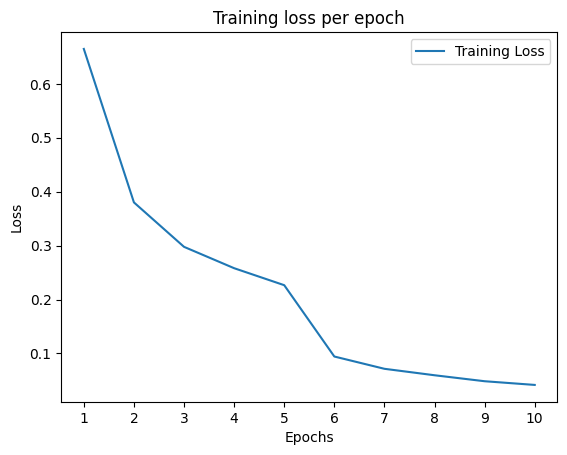

In [ ]:
train(cnn_model_alex_pretrained, train_loader,val_loader)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy using 5400 test images: 97.01851654052734 %

Accuracy of  0 : 97 % in 600 Images
Recall of  0 : 0.9716666666666667  
Precision of  0 : 0.9433656957928802  
Accuracy of  1 : 98 % in 600 Images
Recall of  1 : 0.9866666666666667  
Precision of  1 : 0.9949579831932773  
Accuracy of  2 : 96 % in 600 Images
Recall of  2 : 0.9666666666666667  
Precision of  2 : 0.9385113268608414  
Accuracy of  3 : 97 % in 500 Images
Recall of  3 : 0.976  
Precision of  3 : 0.9779559118236473  
Accuracy of  4 : 97 % in 500 Images
Recall of  4 : 0.972  
Precision of  4 : 0.9858012170385395  
Accuracy of  5 : 94 % in 400 Images
Recall of  5 : 0.94  
Precision of  5 : 0.9665809768637532  
Accuracy of  6 : 92 % in 500 Images
Recall of  6 : 0.926  
Precision of  6 : 0.9429735234215886  
Accuracy of  7 : 99 % in 600 Images
Recall of  7 : 0.9916666666666667  
Precision of  7 : 0.9754098360655737  
Accuracy of  8 : 95 % in 500 Images
Recall of  8 : 0.958  
Precision of  8 : 0.9917184265010351  
Accuracy of  

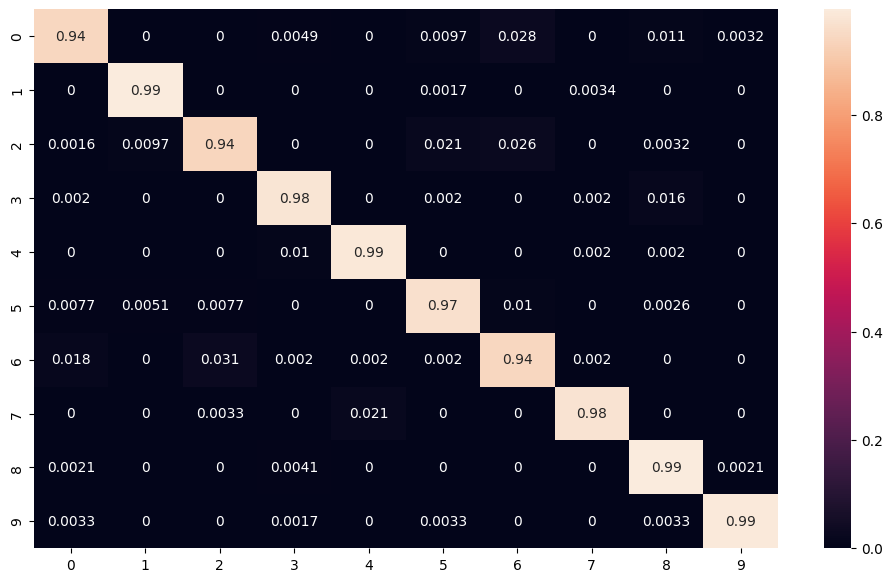

In [ ]:
test(cnn_model_alex_pretrained, test_loader, 10)

##Implementing the late fusion that is a task of part 2




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy using 5400 test images: 97.75926208496094 %

Accuracy of  0 : 96 % in 600 Images
Recall of  0 : 0.9666666666666667  
Precision of  0 : 0.9602649006622517  
Accuracy of  1 : 99 % in 600 Images
Recall of  1 : 0.9916666666666667  
Precision of  1 : 1.0  
Accuracy of  2 : 97 % in 600 Images
Recall of  2 : 0.9783333333333334  
Precision of  2 : 0.942215088282504  
Accuracy of  3 : 98 % in 500 Images
Recall of  3 : 0.988  
Precision of  3 : 0.9801587301587301  
Accuracy of  4 : 98 % in 500 Images
Recall of  4 : 0.98  
Precision of  4 : 0.9919028340080972  
Accuracy of  5 : 95 % in 400 Images
Recall of  5 : 0.9575  
Precision of  5 : 0.9745547073791349  
Accuracy of  6 : 94 % in 500 Images
Recall of  6 : 0.946  
Precision of  6 : 0.9653061224489796  
Accuracy of  7 : 99 % in 600 Images
Recall of  7 : 0.9966666666666667  
Precision of  7 : 0.9867986798679867  
Accuracy of  8 : 96 % in 500 Images
Recall of  8 : 0.964  
Precision of  8 : 0.9877049180327869  
Accuracy of  9 : 99 % in 600

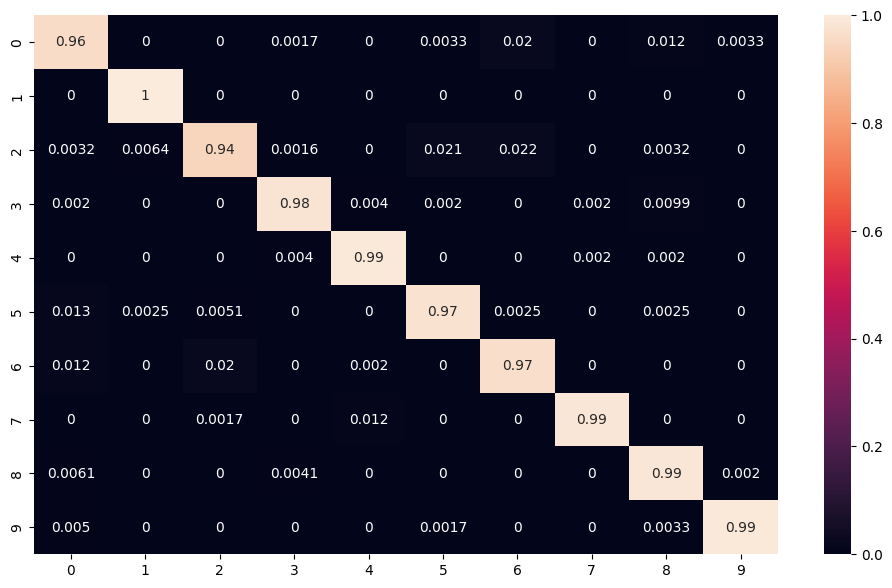

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


num_classes =10
# Evaluate a CNN is similar to the training process without the backpropagation.
# To evaluate a CNN, we need to follow the evaluation metrics
#class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
correct = 0
total = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
class_preds = list(0. for i in range(num_classes))
recalls = list(0. for i in range(num_classes))
precisions = list(0. for i in range(num_classes))

conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]



preds = []
y = []

with torch.no_grad(): # You are not training, so you don't need to calculate gradients
  for batch_id, data in enumerate(test_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Calculate the CNN's predictions by running images through the network
    outputs1 = cnn_model_alex_pretrained(images)
    outputs2 = cnn_model_mobile_pretrained(images)

    # The class with the highest
    combined_outputs = outputs1.data+outputs2.data
    _, predicted = torch.max(combined_outputs, 1)

    # Get model's performance
    # -------------------------------------------------------
    # ----------------- Compute metrics here ----------------
    # -------------------------------------------------------
    correct += sum(predicted==labels)
    labels = labels.detach().cpu().numpy()
    predicted = predicted.detach().cpu().numpy()



    for pred, lab in zip(predicted, labels):
      total += 1
      preds.append(pred)
      y.append(lab)
      class_total[lab] += 1
      class_preds[pred]+=1
      if pred == lab:
        class_correct[lab] += 1

  conf_matrix = confusion_matrix(preds, y)
  conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
  # Adjust this based on the actual number of classes
  df_cm = pd.DataFrame(conf_matrix)
  plt.figure(figsize=(12, 7))
  sns.heatmap(df_cm, annot=True)
  plt.savefig("confusion_matrix.png")
  files.download("confusion_matrix.png")
# Show model's performance
print('Accuracy using {} test images: {} %\n'.format(total,100 * correct / total))
# Performance per Class
for i in range(num_classes):
  if class_total[i] == 0:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 0, 0))
  else:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 100 * class_correct[i] / class_total[i], class_total[i]))
    print('Recall of %2s : %3s  ' % (i, class_correct[i]/ class_total[i] ))
    print('Precision of %2s : %3s  ' % (i, class_correct[i]/ class_preds[i]))
    recalls[i] =class_correct[i]/ class_total[i]
    precisions[i] = class_correct[i]/ class_preds[i]

avg_recall= sum(recalls)/num_classes
avg_precision = sum(precisions)/num_classes
print(f'\nAvarege recall: {avg_recall}')
print(f'\nAvarege precision: {avg_precision}')
print(f'F1 score: {(2*avg_recall*avg_precision)/(avg_recall+avg_precision)}')
